## First Aproach

- Simular $n$ termoeléctricas ($t_i$ es el valor de generación máxima de la termoeléctrica $i$)
- El día 0 funcionan todas
- Si todas funcionan Oferta $\geq$ Demanda
- Simular tiempo de rotura (Weibull)
- Todas se pueden reparar a la vez
- Tiempo de reparación Lognormal
- Existen $m$ circuitos ($c_j$ es el valor de demanda del circuito $j$)
- $\delta_{ik}$ es un parámetro binario que expresa si la termoeléctrica $i$ está activa el día $k$
- $\alpha_{jk}$ es un parámetro binario que expresa si el circuito $j$ está activo el día $k$
- Existe capacidad de almacenamiento ($a_k$ es la capacidad de almacenamiento del sistema en el día $k$)
- $a_0 = 0$
- $a_k = \sum_{i=1}^{n} t_i\delta_{ik} + a_{k-1} - \sum_{j=1}^{m} c_j\alpha_{jk}, a_k \geq 0$
- No simularemos mantenimientos planificados, solo reparación por rotura
- No tendremos en cuenta fallas internas de los circuitos
- No habrán circuitos que dependan de termoeléctricas específicas
- La afectación a los circuitos se hará de manera proporcional (con una proporción que definiremos) y rotativa, cuando sea necesario
- Al final de la simulación calcularemos una afectación (fórmula por determinar)

In [ ]:
# from abc import ABC, abstractmethod
# import math

# class Handler(ABC):

#     @abstractmethod
#     def decision(self, offer, t, circuits, circuits_state):
#         pass

# class RRHandler(Handler):

#     current_index = 0

#     def __init__(self) -> None:
#         super().__init__()

#     def decision(self, offer, t, circuits, circuits_state):
        
#         demand = sum(circuits)

#         while(demand > offer):
#             circuits_state[t][self.current_index] -= math.floor(0.25 * circuits[self.current_index])
#             demand -= math.floor(0.25 * circuits[self.current_index])

#             self.current_index += 1
#             self.current_index %= len(circuits)

#             if circuits_state[t][self.current_index] < 0:
#                 print(str(offer) + " " + str(demand))
#                 raise Exception("Circuit fall below 0")

#         return demand
        
        

In [ ]:
# import probabilistic_models as pm
# import numpy as np
# import random

# def simulate(N, M, K, handler:Handler ,seed=0):

#     if seed != 0:
#         random.seed(seed)

#     thermoelectrics = [random.randint(500, 1000) for _ in range(N)]
#     thermoelectrics_state = [[1 for _ in range(N)]]
#     circuits = [random.randint(200, 600) for _ in range(M)]
#     circuits_state = [[x for x in circuits]]
#     leave_service = [[] for _ in range(K)]
#     re_enter_service = [[] for _ in range(K)]
#     balance = 0
#     demand = sum(x for x in circuits)

#     for i in range(N):
#         pm.break_thermoelectric(leave_service, i, 0, N)

#     for t in range(1, K):
#         circuits_state.append([x for x in circuits])
#         thermoelectrics_state.append([x for x in thermoelectrics_state[t - 1]])
        
#         for thermoelectric in leave_service[t]:
#             thermoelectrics_state[t][thermoelectric] = 0
#             pm.repair_thermoelectric(re_enter_service, thermoelectric, t, N)

#         for thermoelectric in re_enter_service[t]:
#             thermoelectrics_state[t][thermoelectric] = 1
#             pm.break_thermoelectric(leave_service, thermoelectric, t, N)
            
#         offer = sum(x * y for x, y in zip(thermoelectrics, thermoelectrics_state[t])) + balance
#         demand = handler.decision(offer, t, circuits, circuits_state)

#         balance = offer - demand
    
#     return [thermoelectrics_state, circuits_state]

In [ ]:
# thermoelectrics, circuits = simulate(1, 15, 365, RRHandler())

# for i in range(365):
#     print(thermoelectrics[i])

In [ ]:

# import matplotlib.pyplot as plt

# plt.plot([sum(x) for x in thermoelectrics])
# plt.ylabel('Thermoelectrics')
# plt.xlabel('Days')
# plt.show()

# # save for every day the number of thermoelectrics that are working in excel file
# import pandas

# # columns = [f"Thermoelectric {i}" for i in range(60)]
# # rows = [f"Day {i}" for i in range(365)]

# # df = pandas.DataFrame(thermoelectrics, columns=columns, index=rows)



# The New Beginning

In [ ]:
from App.modules.weibull import Weibull
from App.modules.lognormal import LogNormal
from App.modules.event import Event
from App.modules.thermoelectric import ThermoElectric
import random as rnd
import numpy as np

In [ ]:
days = 365
thermoelectrics_amount = 300
thermoelectrics = []
for i in range(thermoelectrics_amount):
    w = Weibull(rnd.uniform(1,3), rnd.randint(5, 300))
    l = LogNormal(rnd.uniform(0,1), rnd.uniform(0,2))
    o = rnd.randrange(0, 1000)
    t = ThermoElectric(o , w, l)
    t.planificate_events(days)
    thermoelectrics.append(t)

In [ ]:
for i in range(20):
    thermoelectrics[i].plot(0, 365)
    thermoelectrics[i].get_distributions_info()

In [ ]:
def get_next_general_event(thermoelectrics_list, days, current_day):
    next_event = days
    next_thermoelectric = None
    for t in thermoelectrics_list:
        tmp = t.get_next_future_event_day()
        if tmp < next_event and tmp > current_day:
            next_event = tmp
            next_thermoelectric = t
    return (next_event, next_thermoelectric)

In [ ]:
get_next_general_event(thermoelectrics, days, 4)

In [ ]:
def simulate(sim_thermoelectrics, days):
    current_day = 0
    working_thermoelectrics = []
    working_thermoelectrics.append(len(sim_thermoelectrics))
    while current_day < days:
        next_event, next_thermoelectric = get_next_general_event(sim_thermoelectrics, days, current_day)
        for i in range(int(np.floor(current_day)), int(np.floor(next_event))-1):
            working_thermoelectrics.append(working_thermoelectrics[-1])
        current_day = next_event
        if next_thermoelectric is not None:
            next_thermoelectric.pop_next_future_event()
            while True:
                new_next_event, new_next_thermoelectric = get_next_general_event(sim_thermoelectrics, days, current_day)
                if np.floor(current_day) == np.floor(new_next_event):
                    new_next_thermoelectric.pop_next_future_event()
                    current_day = new_next_event
                else: 
                    break
            count = 0
            for t in sim_thermoelectrics:
                if t.is_working():
                    count += 1
            working_thermoelectrics.append(count)

        else:
            working_thermoelectrics.append(working_thermoelectrics[-1])
            break
    return working_thermoelectrics

In [ ]:
import copy

tmp = copy.deepcopy(thermoelectrics)
working_thermoelectrics = simulate(tmp, days)

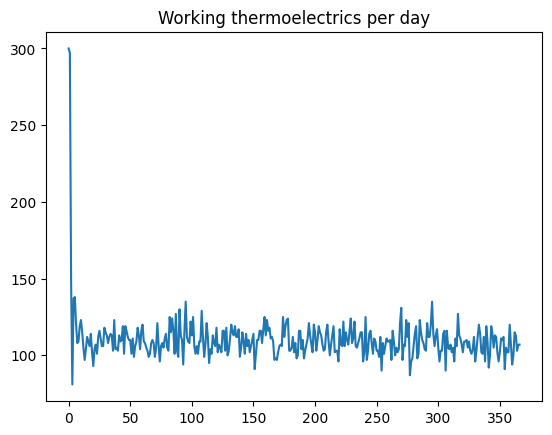

In [23]:
import matplotlib.pyplot as plt

plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
# plt.xlabel('Days')
# plt.ylabel('Working thermoelectrics')
plt.show()